가우시안 노이즈와 드롭아웃은 정규화 레이어라 학습 시에만 활성화되므로, 평가/시각화 시에는 입력에 별도 레이어를 강제로 적용해 훼손본을 만들어 통과시키는 방식이 사용됩니다.

노이즈 주입 방식: 인코더 초입에서 GaussianNoise 또는 Dropout으로 입력을 훼손하고, 디코더가 원본을 복원하도록 학습시켜 더욱 견고한 표현을 학습하게 합니다.

구현 포인트: GaussianNoise/Dropout은 정규화 레이어이므로 추론(inference) 시에는 비활성화되어, 테스트 시에는 해당 레이어를 따로 호출하여 훼손된 입력을 만들어 모델에 넣어야 합니다.

모델 구조: Flatten → 노이즈(또는 드롭아웃) → Dense(100, selu) → Dense(30, selu) 인코더와, Dense(100, selu) → Dense(784, sigmoid) → Reshape(28,28) 디코더를 사용합니다.

## 파이프라인 설계
데이터 전처리: MNIST를 0~1 범위로 정규화하고, 학습/검증/테스트 셋을 구성합니다.

훼손 생성: 훈련 시에는 모델 안의 GaussianNoise/Dropout이 자동 적용되며, 검증 시각화에서는 동일한 레이어를 별도로 호출하여 training=True로 훼손본을 생성합니다.

모델 학습: 손실은 binary_crossentropy, 평가는 픽셀을 0.5 임계로 반올림해 일치율을 계산하는 rounded_accuracy를 사용합니다.

모델 변형: GaussianNoise 기반 모델과 Dropout 기반 모델을 각각 동일한 디코더로 학습해 비교합니다.

In [1]:
# Cell 1: Environment setup (Colab/Jupyter)
# Note: In Colab, upgrading TensorFlow may require a runtime restart.
# !pip -q install -U "tensorflow>=2.16" "numpy>=1.26" "matplotlib>=3.8"

import os, sys, platform, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Python :", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("NumPy     :", np.__version__)

# GPU check
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Reproducibility
seed = 42
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)


Python : 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
TensorFlow: 2.19.0
NumPy     : 2.0.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Cell 2: Load and preprocess MNIST
from tensorflow.keras.datasets import mnist

# Load MNIST
(x_train_full, _), (x_test, _) = mnist.load_data()

# Normalize to [0,1]
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Create train/valid split from the original 60k training examples
x_train, x_valid = x_train_full[:50000], x_train_full[50000:]

print("Train:", x_train.shape, x_train.dtype)
print("Valid:", x_valid.shape, x_valid.dtype)
print("Test :", x_test.shape, x_test.dtype)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train: (50000, 28, 28) float32
Valid: (10000, 28, 28) float32
Test : (10000, 28, 28) float32


MNIST를 로드하여 0~1 스케일로 정규화하고, 학습/검증/테스트 세트를 준비합니다.

In [3]:
# Cell 3: Utilities - metric and visualization
import tensorflow.keras.backend as K

@tf.function
def rounded_accuracy(y_true, y_pred):
    # Round both true and pred at 0.5 and compute mean equality
    yt = tf.cast(tf.greater_equal(y_true, 0.5), tf.float32)
    yp = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(yt, yp), tf.float32))

def show_reconstructions(model, inputs, n=10, title=None):
    idx = np.random.choice(len(inputs), size=n, replace=False)
    samples = inputs[idx]
    recons = model.predict(samples, verbose=0)

    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        # Corrupted or clean input
        ax = plt.subplot(2, n, i+1)
        plt.imshow(samples[i], cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
        if i == 0 and title:
            ax.set_title(title)

        # Reconstruction
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(recons[i], cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()


픽셀을 0.5 임계로 반올림해 일치율을 구하는 rounded_accuracy와, 원본/복원본을 나란히 보여주는 함수를 정의합니다.


오토인코더의 정확도는 분류 정확도와 다르며, 복원된 픽셀을 0.5 기준으로 이진화해 원본과 일치 비율을 계산합니다.

## 가우시안 노이즈 기반 DAE

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3327 - rounded_accuracy: 0.8314 - val_loss: 0.2173 - val_rounded_accuracy: 0.9000
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2079 - rounded_accuracy: 0.9053 - val_loss: 0.1824 - val_rounded_accuracy: 0.9190
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1815 - rounded_accuracy: 0.9198 - val_loss: 0.1681 - val_rounded_accuracy: 0.9273
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1684 - rounded_accuracy: 0.9271 - val_loss: 0.1571 - val_rounded_accuracy: 0.9334
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1584 - rounded_accuracy: 0.9328 - val_loss: 0.1484 - val_rounded_accuracy: 0.9385
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1507 - rounded_accuracy: 0.9373 - val_loss: 0.1422 - val_rounded_accuracy: 0.9424
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1450 - rounded_accuracy: 0.9405 - val_loss: 0.1374 - val_rounded_accuracy

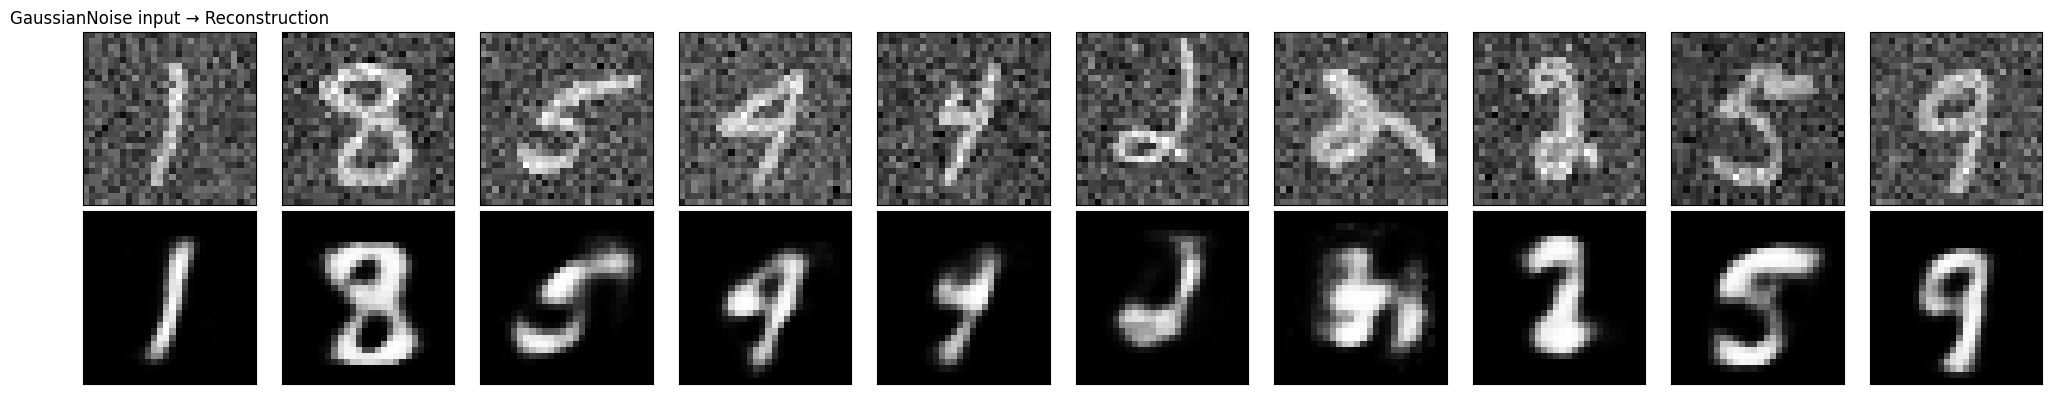

In [4]:
# Cell 4: Denoising Autoencoder with GaussianNoise
from tensorflow import keras
from tensorflow.keras import layers

# Encoder
denoising_encoder = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.GaussianNoise(0.2),        # noise only active during training
    layers.Dense(100, activation="selu"),
    layers.Dense(30, activation="selu")
], name="gaussian_encoder")

# Decoder
denoising_decoder = keras.Sequential([
    layers.Dense(100, activation="selu", input_shape=(30,)),
    layers.Dense(28 * 28, activation="sigmoid"),
    layers.Reshape((28, 28))
], name="gaussian_decoder")

denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder], name="gaussian_dae")
denoising_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=[rounded_accuracy]
)

hist_gn = denoising_ae.fit(
    x_train, x_train,
    validation_data=(x_valid, x_valid),
    epochs=10, batch_size=128, verbose=1
)

# Visualize on corrupted validation inputs
gn_corrupt = layers.GaussianNoise(0.2)
x_valid_gn = gn_corrupt(x_valid, training=True).numpy()  # force corruption at "inference"
show_reconstructions(denoising_ae, x_valid_gn, n=10, title="GaussianNoise input → Reconstruction")


Flatten → GaussianNoise(0.2) → Dense(100, selu) → Dense(30, selu) 인코더와 대칭 디코더를 구성하고, binary_crossentropy+SGD로 학습합니다.

## 드롭아웃 기반 DAE

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.3354 - rounded_accuracy: 0.8272 - val_loss: 0.2276 - val_rounded_accuracy: 0.8925
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2193 - rounded_accuracy: 0.8981 - val_loss: 0.1869 - val_rounded_accuracy: 0.9164
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1898 - rounded_accuracy: 0.9148 - val_loss: 0.1715 - val_rounded_accuracy: 0.9249
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1775 - rounded_accuracy: 0.9215 - val_loss: 0.1618 - val_rounded_accuracy: 0.9307
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1702 - rounded_accuracy: 0.9254 - val_loss: 0.1558 - val_rounded_accuracy: 0.9337
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1648 - rounded_accuracy: 0.9283 - val_loss: 0.1504 - val_rounded_accuracy: 0.9372
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1603 - rounded_accuracy: 0.9310 - val_loss: 0.1460 - val_rounded_accuracy:

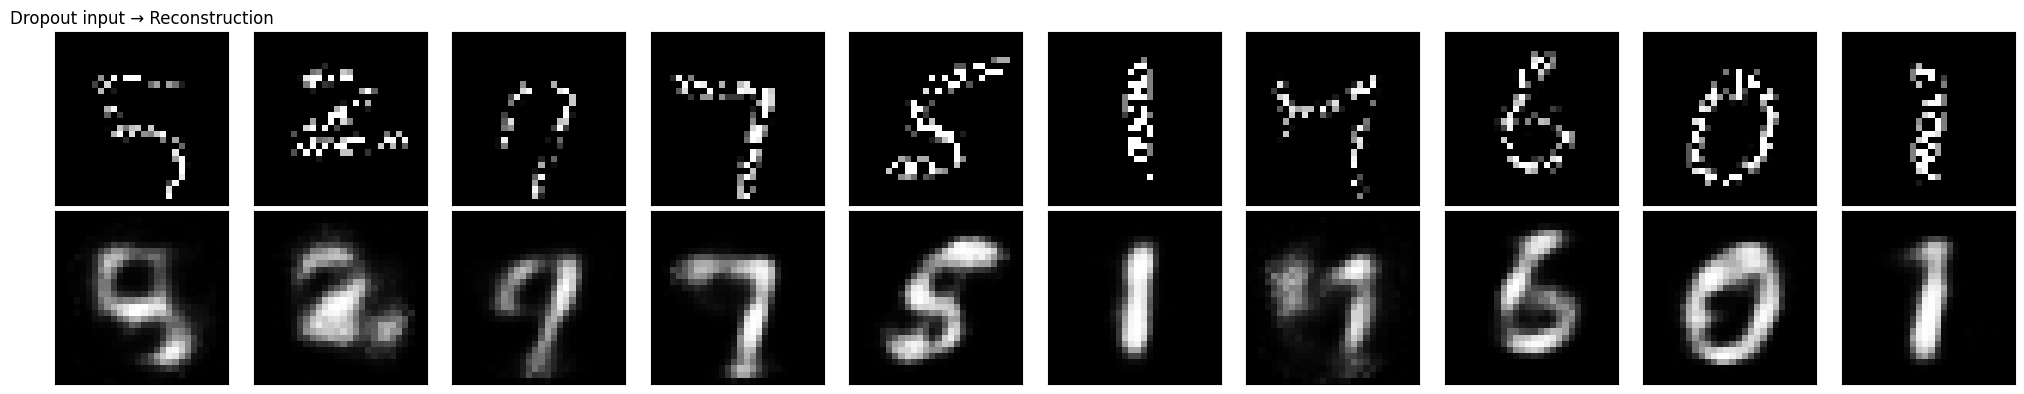

In [5]:
# Cell 5: Denoising Autoencoder with Dropout
dropout_encoder = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dropout(0.5),              # dropout only active during training
    layers.Dense(100, activation="selu"),
    layers.Dense(30, activation="selu")
], name="dropout_encoder")

dropout_decoder = keras.Sequential([
    layers.Dense(100, activation="selu", input_shape=(30,)),
    layers.Dense(28 * 28, activation="sigmoid"),
    layers.Reshape((28, 28))
], name="dropout_decoder")

dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder], name="dropout_dae")
dropout_ae.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=1.0),
    metrics=[rounded_accuracy]
)

hist_do = dropout_ae.fit(
    x_train, x_train,
    validation_data=(x_valid, x_valid),
    epochs=10, batch_size=128, verbose=1
)

# Visualize on corrupted validation inputs (force dropout corruption)
do_corrupt = layers.Dropout(0.5)
x_valid_do = do_corrupt(x_valid, training=True).numpy()
show_reconstructions(dropout_ae, x_valid_do, n=10, title="Dropout input → Reconstruction")


Flatten → Dropout(0.5) → Dense(100, selu) → Dense(30, selu) 인코더와 동일한 디코더로 학습하며, 시각화 시에는 Dropout 레이어를 별도로 호출해 훼손본을 만듭니다.

## 컨볼루션 DAE

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.2282 - val_loss: 0.1037
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1007 - val_loss: 0.0954
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0944 - val_loss: 0.0928
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0917 - val_loss: 0.0910
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0901 - val_loss: 0.0895


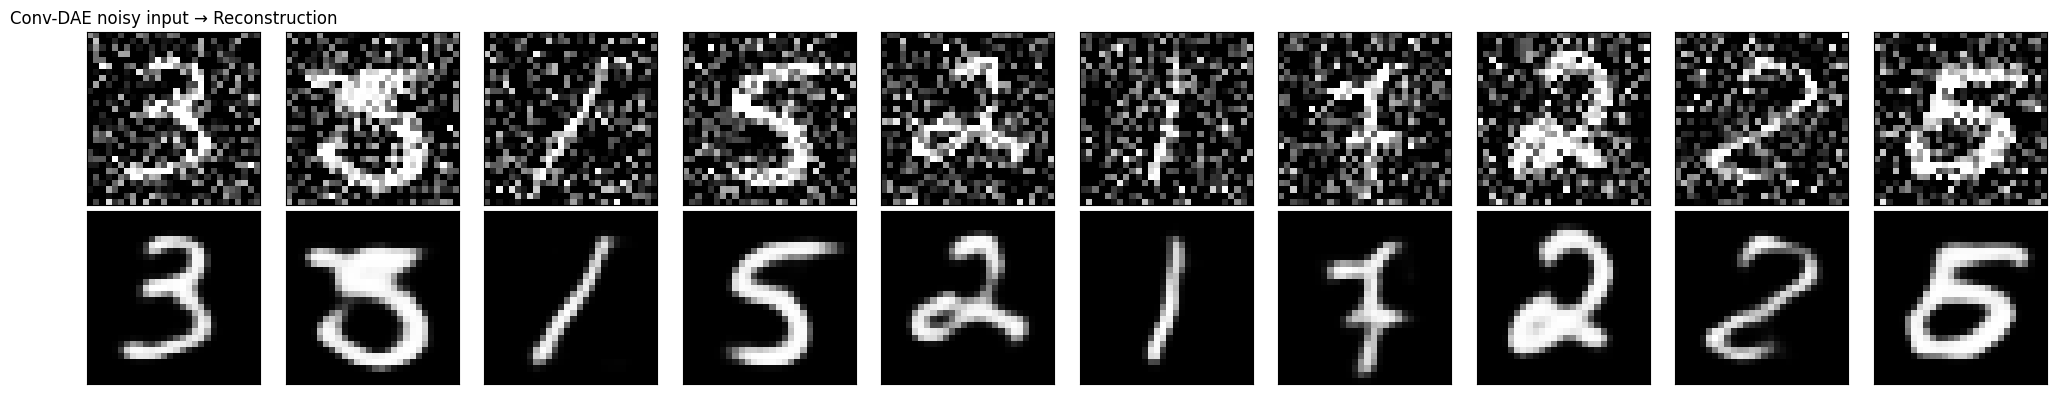

In [6]:
# Cell 6 (Optional): Simple Convolutional DAE for comparison
from tensorflow.keras import Model

def build_conv_dae():
    inp = layers.Input(shape=(28,28,1))
    # Encoder
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, padding="same")(x)
    # Decoder
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D(2)(x)
    out = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
    return Model(inp, out, name="conv_dae")

# Prepare data (expand channels)
x_train_c = np.expand_dims(x_train, -1)
x_valid_c = np.expand_dims(x_valid, -1)

# Create noisy inputs externally (data augmentation style)
noise_factor = 0.4
x_train_noisy = np.clip(x_train_c + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train_c.shape), 0.0, 1.0)
x_valid_noisy = np.clip(x_valid_c + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_valid_c.shape), 0.0, 1.0)

conv_dae = build_conv_dae()
conv_dae.compile(optimizer="adam", loss="binary_crossentropy")

conv_dae.fit(
    x_train_noisy, x_train_c,
    validation_data=(x_valid_noisy, x_valid_c),
    epochs=5, batch_size=128, verbose=1
)

# Quick visualization
def display_pairs(a1, a2, n=10, title=None):
    idx = np.random.choice(len(a1), size=n, replace=False)
    s1, s2 = a1[idx], a2[idx]
    plt.figure(figsize=(2*n, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(s1[i].squeeze(), cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
        if i == 0 and title:
            ax.set_title(title)
        ax = plt.subplot(2, n, i+1+n)
        rec = conv_dae.predict(s1[i:i+1], verbose=0)
        plt.imshow(rec.squeeze(), cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()

display_pairs(x_valid_noisy, x_valid_c, n=10, title="Conv-DAE noisy input → Reconstruction")


컨볼루션 기반 구조로 노이즈 주입을 데이터 증강처럼 처리하여 성능과 시각적 품질을 개선하는 방법을 보여줍니다.

컨볼루션 기반 DAE는 지역 구조를 더 잘 보존해 시각적 복원 품질이 좋게 나오는 경우가 많으며, Keras 예시를 참고해 간단히 확장할 수 있습니다.

In [8]:
# Cell A: 공통 정확도(metric)와 평가 유틸
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

@tf.function
def rounded_accuracy(y_true, y_pred):
    yt = tf.cast(tf.greater_equal(y_true, 0.5), tf.float32)
    yp = tf.cast(tf.greater_equal(y_pred, 0.5), tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(yt, yp), tf.float32))

def compute_acc(model, x_in, x_target):
    # 모델 출력과 타깃의 rounded pixel-wise accuracy
    y_pred = model.predict(x_in, verbose=0)
    return float(rounded_accuracy(x_target, y_pred).numpy())


In [9]:
# Cell B: 셀 6(Conv-DAE) 정확도 출력
# 전제: conv_dae, x_valid_noisy, x_valid_c 가 이미 존재 (셀 6에서 학습 완료)
conv_val_acc = compute_acc(conv_dae, x_valid_noisy, x_valid_c)
print(f"Cell 6 (Conv-DAE) validation rounded accuracy: {conv_val_acc:.4f}")


Cell 6 (Conv-DAE) validation rounded accuracy: 0.9729


Cell 4 (Gaussian DAE) validation rounded accuracy: 0.9480
Cell 5 (Dropout  DAE) validation rounded accuracy: 0.9382
Cell 6 (Conv-DAE)     validation rounded accuracy: 0.9729


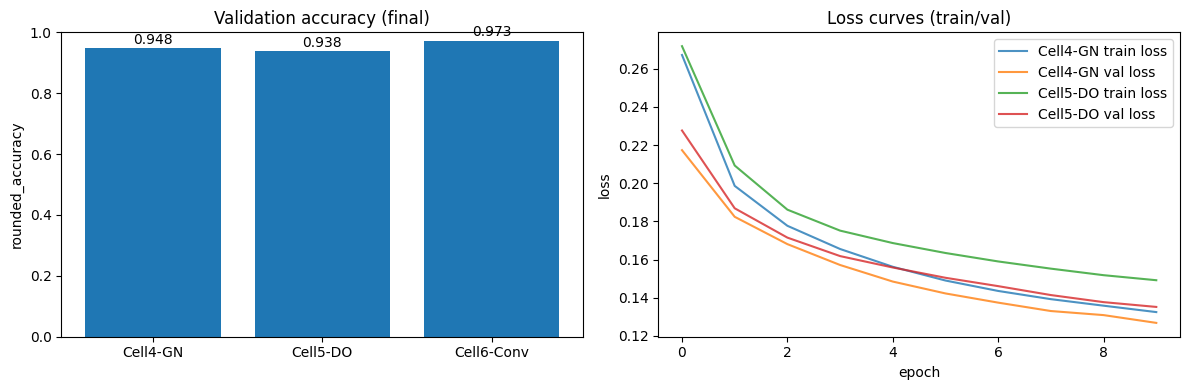

In [10]:
# Cell C: 셀 4·5·6 손실/정확도 곡선 비교 시각화
# 전제:
# - hist_gn: GaussianNoise DAE (셀 4) history
# - hist_do: Dropout DAE (셀 5) history
# - conv_dae: Conv-DAE (셀 6) model
# - x_valid_noisy / x_valid_c: Conv-DAE의 검증 입력/타깃
# - x_valid_gn: GaussianNoise DAE의 훼손 입력 (training=True로 만든 것)
# - x_valid_do: Dropout DAE의 훼손 입력 (training=True로 만든 것)

# 각 모델의 '최종' 검증 정확도 계산
gn_val_acc = compute_acc(denoising_ae, x_valid_gn, x_valid)      # 셀 4
do_val_acc = compute_acc(dropout_ae,   x_valid_do, x_valid)      # 셀 5
cv_val_acc = compute_acc(conv_dae,     x_valid_noisy, x_valid_c) # 셀 6

print(f"Cell 4 (Gaussian DAE) validation rounded accuracy: {gn_val_acc:.4f}")
print(f"Cell 5 (Dropout  DAE) validation rounded accuracy: {do_val_acc:.4f}")
print(f"Cell 6 (Conv-DAE)     validation rounded accuracy: {cv_val_acc:.4f}")

# 손실 곡선: hist_gn / hist_do는 존재, Conv-DAE는 history 객체를 사용하지 않았다면 재학습하거나 생략 가능
# 만약 conv_dae 학습 시 history를 conv_hist로 받아두었다면 아래에 포함
has_conv_hist = 'conv_hist' in globals()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Validation accuracy (final)")
bars = plt.bar(["Cell4-GN","Cell5-DO","Cell6-Conv"], [gn_val_acc, do_val_acc, cv_val_acc])
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.005, f"{b.get_height():.3f}", ha='center', va='bottom')
plt.ylim(0,1)
plt.ylabel("rounded_accuracy")

plt.subplot(1,2,2)
plt.title("Loss curves (train/val)")
# Gaussian DAE curves
plt.plot(hist_gn.history["loss"], label="Cell4-GN train loss", alpha=0.8)
plt.plot(hist_gn.history["val_loss"], label="Cell4-GN val loss", alpha=0.8)
# Dropout DAE curves
plt.plot(hist_do.history["loss"], label="Cell5-DO train loss", alpha=0.8)
plt.plot(hist_do.history["val_loss"], label="Cell5-DO val loss", alpha=0.8)
# Conv-DAE curves (있는 경우만)
if has_conv_hist:
    plt.plot(conv_hist.history["loss"], label="Cell6-Conv train loss", alpha=0.8)
    plt.plot(conv_hist.history["val_loss"], label="Cell6-Conv val loss", alpha=0.8)

plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
plt.show()


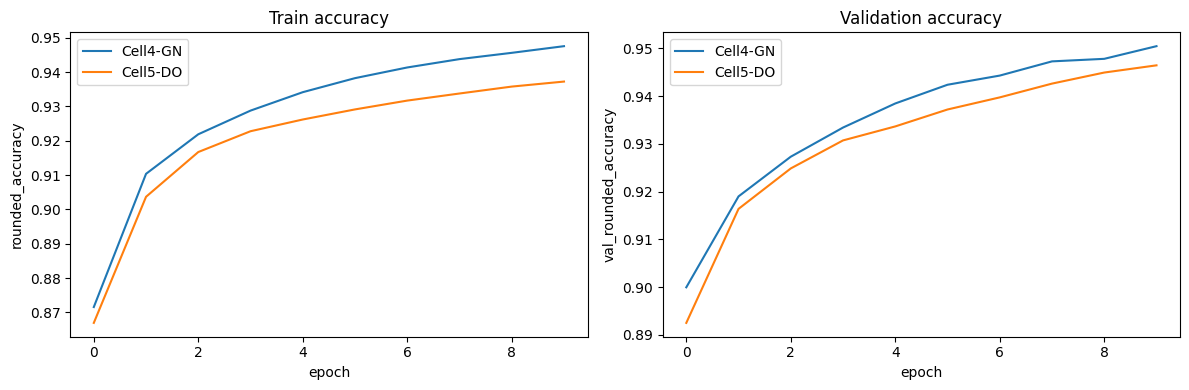

In [11]:
# Cell D (선택): 정확도 곡선도 함께 보고 싶다면 (hist에 metric이 존재해야 함)
# 전제: 셀 4/5는 compile에서 metrics=[rounded_accuracy] 사용, hist_gn / hist_do에 존재
has_gn_acc = "rounded_accuracy" in hist_gn.history and "val_rounded_accuracy" in hist_gn.history
has_do_acc = "rounded_accuracy" in hist_do.history and "val_rounded_accuracy" in hist_do.history
has_cv_acc = 'conv_hist' in globals() and ("rounded_accuracy" in conv_hist.history)

if has_gn_acc or has_do_acc or has_cv_acc:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title("Train accuracy")
    if has_gn_acc:
        plt.plot(hist_gn.history["rounded_accuracy"], label="Cell4-GN")
    if has_do_acc:
        plt.plot(hist_do.history["rounded_accuracy"], label="Cell5-DO")
    if has_cv_acc:
        plt.plot(conv_hist.history["rounded_accuracy"], label="Cell6-Conv")
    plt.xlabel("epoch"); plt.ylabel("rounded_accuracy"); plt.legend()

    plt.subplot(1,2,2)
    plt.title("Validation accuracy")
    if has_gn_acc:
        plt.plot(hist_gn.history["val_rounded_accuracy"], label="Cell4-GN")
    if has_do_acc:
        plt.plot(hist_do.history["val_rounded_accuracy"], label="Cell5-DO")
    if has_cv_acc:
        plt.plot(conv_hist.history["val_rounded_accuracy"], label="Cell6-Conv")
    plt.xlabel("epoch"); plt.ylabel("val_rounded_accuracy"); plt.legend()
    plt.tight_layout(); plt.show()
else:
    print("Note: Conv-DAE는 metrics를 지정하지 않아 정확도 곡선 history가 없습니다. 필요 시 compile(metrics=[rounded_accuracy])로 재학습하세요.")


손실·정확도 곡선 플롯은 Keras History 딕셔너리에서 꺼내 그리며, 테스트/추가 지표는 별도의 평가 단계를 통해 병행할 수 있습니다.